<a href="https://colab.research.google.com/github/brarkaranbir/LLM-weight-quantization-/blob/main/Assignment_quantization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Optimization problem**

vector v = [3.2, -1.4, 2.5, -0.9, 1.8, -3.7, 0.0, 4.0, 2.2, -1.3]

quantization grid for 8 embeddings in -4 to 4 range:

the step size for uniforn distance is 8/7, we need 7 steps to map 8 values in the space -4 to 4. the step size is 1.143.
the grid q : [−4,−2.857,−1.714,−0.571,0.571,1.714,2.857,4]

L2 norm minimization will be the closest euclidean distance for each value in vector v from values of the q. the Value of q with the least distance would be the quantization for the vector v.



In [ ]:
import numpy as np

v= [3.2, -1.4, 2.5, -0.9, 1.8, -3.7, 0.0, 4.0, 2.2, -1.3]
q= np.linspace(-4,4,8)
indice=np.searchsorted(q,v)
left= q[indice-1]
right= q[indice]
quantized_vector = np.where((v-left)<(right-v),left,right)
print(quantized_vector)



[ 2.85714286 -1.71428571  2.85714286 -0.57142857  1.71428571 -4.
  0.57142857  4.          1.71428571 -1.71428571]


**Large-Scale Vector Consideration:** Assuming the vector v is large (e.g., 10 billion elements), propose a method to accelerate the solution to the optimization problem.


To handle large vector sizes we can use batch processing. That is input the vector in batches and concatenate the quantized vector batches at the end.
Once the vector is converted into batches we can parallelise the process to either run on multiple cpu cores or to use GPU.
Since we are dealing with 1-D vectors it makes sense to use the binary search instead of nearest neighbour algorithms as it requires less memory than nearest neighbour algorithms.

In [8]:
import numpy as np
from sklearn.mixture import GaussianMixture
import time
import matplotlib.pyplot as plt

large_vector= np.random.normal(0,1,size=10**8)
large_vector=np.clip(large_vector,-4,4)
sample_sizes=[10**3,10**4,10**5,10**6,10**7]

L2_errors =[]
times =[]
quantization_levels_list =[]

def quantize_vector(v, q):
  indice = np.searchsorted(q, v)
  indices =np.clip(indice,1, len(q)-1)
  left= q[indices -1]
  right = q[indices]
  quantized_vector= np.where(np.abs(v-left)<np.abs(right-v),left,right)
  return quantized_vector


In [9]:
for s in sample_sizes:
  sample_indices = np.random.choice(large_vector.shape[0], size=s, replace = False)
  sample= large_vector[sample_indices]

  gmm= GaussianMixture(n_components=8,random_state=42)
  start_time= time.time()
  gmm.fit(sample.reshape(-1,1))

  quantization_levels=gmm.means_.flatten()
  quantization_levels_list.append(quantization_levels)

  quantized_vector= quantize_vector(large_vector,quantization_levels)
  L2_error= np.sum((large_vector-quantized_vector)**2)/large_vector.size
  L2_errors.append(L2_error)

  elapsed_time= time.time()- start_time
  times.append(elapsed_time)

  print(f'Sample_size: {s}, L2_norm_error: {L2_error:.6f}, time: {elapsed_time:.4f} seconds')
  print(f'Quantiztion grid for sample size {s}: {np.sort(quantization_levels)}')

Sample_size: 1000, L2_norm_error: 0.282875, time: 6.2059 seconds
Quantiztion grid for sample size 1000: [-1.57531471 -0.91920862 -0.47101207 -0.00235405  0.434081    0.88833918
  1.4894969   2.20124741]
Sample_size: 10000, L2_norm_error: 0.722189, time: 5.8734 seconds
Quantiztion grid for sample size 10000: [-2.13078048 -1.44391784 -0.92433049 -0.43619003  0.06787607  0.57139441
  1.14612815  1.89824149]
Sample_size: 100000, L2_norm_error: 0.285621, time: 6.4970 seconds
Quantiztion grid for sample size 100000: [-2.01886072 -1.3506932  -0.78360395 -0.27570511  0.21096021  0.718816
  1.30103225  1.97907256]
Sample_size: 1000000, L2_norm_error: 0.506598, time: 12.3949 seconds
Quantiztion grid for sample size 1000000: [-1.94721385 -1.25898743 -0.68811483 -0.19272388  0.2786304   0.77339811
  1.33966909  2.01800257]
Sample_size: 10000000, L2_norm_error: 0.501297, time: 77.4847 seconds
Quantiztion grid for sample size 10000000: [-1.99374937 -1.31666092 -0.75141692 -0.2596139   0.21195384  0.

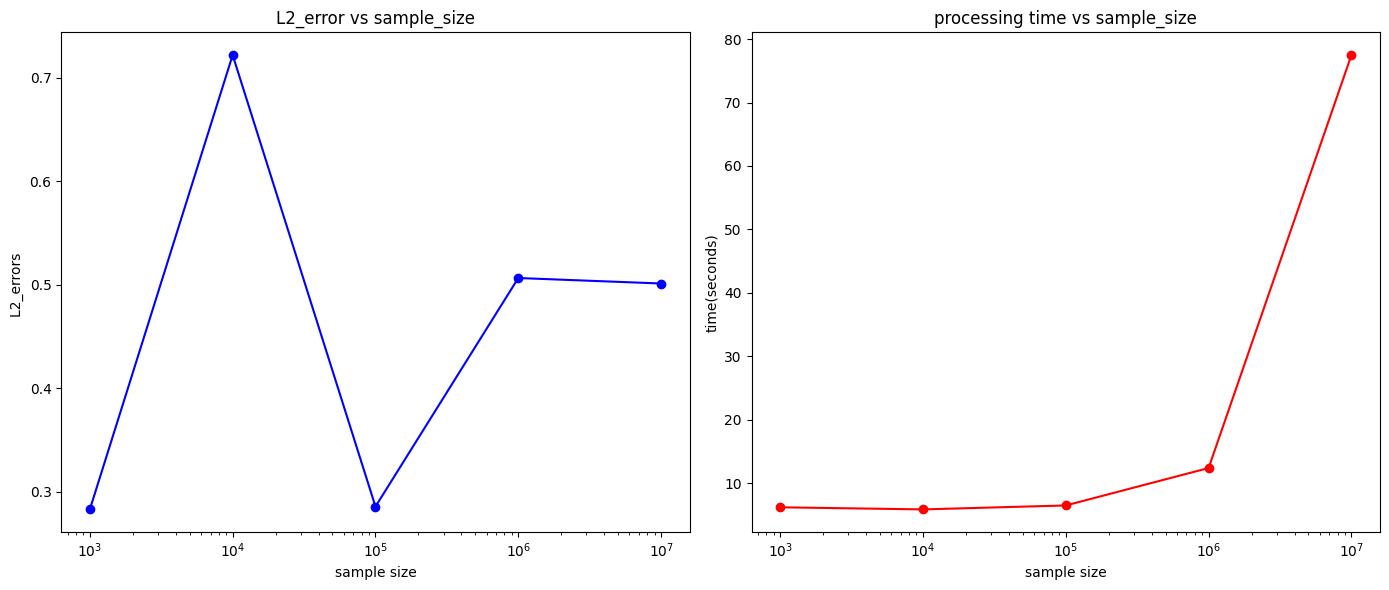

In [10]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.plot(sample_sizes,L2_errors, marker='o', color = 'b' )
plt.xlabel('sample size')
plt.ylabel('L2_errors ')
plt.xscale('log')
plt.title('L2_error vs sample_size')

plt.subplot(1,2,2)
plt.plot(sample_sizes,times, marker='o', color = 'r' )
plt.xlabel('sample size')
plt.ylabel('time(seconds)')
plt.xscale('log')
plt.title('processing time vs sample_size')
plt.tight_layout()
plt.show()

**Non-Uniform Quantization Grid:**The problem formulation can be done as follows.

we need to use non uniform quantization to capture the data spread better and have multiple quantization elements to represent high density areas.

1. quantization grid: I computed the quantization grid by randomly sampling elements from the vector and applying the Gaussian mixture model with 8 componenets and using the means of the GMM model as the quantization grid.
2. L2 norm optimization: we can perform the L2 norm optimization by random initiation of the GMM model multiple times and taking the mean of closely placed elements in the quantization grid. we can also use the expectation maximisation technique for L2 norm optimization.
3. Quantizing the vector. once we have the quantization grid, we can have quantize the vector using the method that we used in part1 .

Mathematical model: This problem can be classified as a non-linear optimization problem due to the squared distance in the objective function. we can use clustering techniques, such as KNN and we can also use GMM. If we had multi dimensional vectors, more complex deep learning and machine learning models are a better option.

solution: randomly sample a number of elements from the vector. Apply gaussian mixture model to get the mean. Use either expectaion maximisation or average multiple quantisation grids. this will help us optimize L2 norm. Quantize the vector using the quantized grid.